In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1334489662981162001
 xla_global_id: -1]

In [3]:
!pip install -q keras_tuner

     |████████████████████████████████| 98 kB 4.3 MB/s 


In [4]:
import numpy as np                                                ###Importing the relevant libraries
import matplotlib.pyplot as plt
import os 
import cv2
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tensorflow.keras.utils import to_categorical

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!unzip -uq "/content/drive/My Drive/Car Damage Claassifier.zip" -d "/content/drive/My Drive/OUTPUT"

In [7]:
DATADIR = "/content/drive/My Drive/OUTPUT/Car Damage Claassifier/training"   
CATEGORIES = ["00-damage","01-whole"]

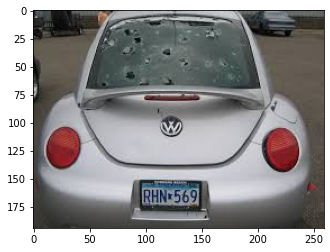

In [8]:
for category in CATEGORIES:                                                              
    path = os.path.join(DATADIR,category)                        ###Directing the path of images and plotting the sample
    for img in os.listdir(path):
        im_array = cv2.imread(os.path.join(path,img))
        img_array = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
        plt.imshow(img_array, cmap = 'rainbow')
        plt.show
        break
    break

In [9]:
img_array.shape

(194, 259, 3)

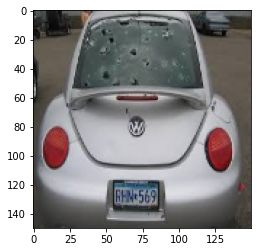

In [10]:
IMG_SIZE = 150

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))               ###Resizing the image according to the GPU
plt.imshow(new_array, cmap='gray')
plt.show()

In [11]:
training_data = []

def create_training_data():
    for category in CATEGORIES: 
        path = os.path.join(DATADIR,category)                        ###Creating training data for both classes 
        class_num = CATEGORIES.index(category) 
        for img in tqdm(os.listdir(path)):  
            try:
                im_array = cv2.imread(os.path.join(path,img))  
                img_array = cv2.cvtColor(im_array, cv2.COLOR_BGR2RGB)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE),3) 
                training_data.append([new_array, class_num])  
            except Exception as e:  
                pass
            

create_training_data()

100%|██████████| 920/920 [00:23<00:00, 38.88it/s] 


In [12]:
len(training_data)

1840

In [13]:
import random                                       ###Shuffling the data
random.shuffle(training_data)

In [14]:
X = []
y = []                                                         ###Dividing it into features and label
for feature,label in training_data:
    X.append(feature)
    y.append(label)

In [15]:
X = np.array(X)/255                              ###Converting the arrays between 0 and 1
y = np.array(y)

In [16]:
print(X.shape, y.shape)

(1840, 150, 150, 3) (1840,)


In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [18]:
x_train = x_train.reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [19]:
x_test = x_test.reshape(-1,IMG_SIZE,IMG_SIZE,3)              ###Resizing(2)

In [20]:
x_train.shape

(1472, 150, 150, 3)

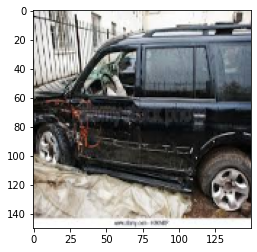

In [21]:
plt.imshow(x_train[2])

In [22]:
y_train

array([1, 1, 0, ..., 0, 0, 1])

In [23]:
y_train = to_categorical(y_train,2)                      ###Getting shape of (,5) for labels
y_test = to_categorical(y_test,2)

In [24]:
classes = len(np.unique(y))                          

In [ ]:
hype = tuner_search.get_best_hyperparameters(num_trials=1)

In [25]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

datagen.fit(x_train)

For Data Augmentation, ImageDataGenerator is used. I have tried training the model with multiple case argumnets in datagen but the above argumemnts gave the best case possible. The data was increased using horizontal_flipping and vertical_flipping which gave the best validation accuracy provided the large variance in the dataset. When increasing data augmentation techniques, it was found that the model was overfitting..


In [26]:
model2 = Sequential()                     ###Conv2D model
model2.add(Conv2D(filters = 80, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model2.add(MaxPooling2D(pool_size=(2,2)))


model2.add(Conv2D(filters = 48, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model2.add(Flatten())
model2.add(Dense(32))
model2.add(Activation('relu'))
model2.add(Dense(classes, activation = "softmax"))

In [27]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 80)      6080      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 80)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 48)        34608     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 48)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65712)             0         
                                                                 
 dense (Dense)               (None, 32)                2

In [28]:
model2.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [29]:
x_train.shape

(1472, 150, 150, 3)

In [30]:
from keras.callbacks import ReduceLROnPlateau   ###Using ReduceLROnPlateau due to the inconsistent dataset
red_lr= ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1)

In [31]:
model2.fit(datagen.flow(x_train,y_train, batch_size=32),epochs = 10, verbose = 1,callbacks=[red_lr],validation_data = (x_test,y_test), steps_per_epoch=x_train.shape[0] // 32)

Epoch 1/10
46/46 [==============================] - 92s 2s/step - loss: 0.6915 - accuracy: 0.5462 - val_loss: 0.6608 - val_accuracy: 0.6549 - lr: 1.0000e-04
Epoch 2/10
46/46 [==============================] - 91s 2s/step - loss: 0.6312 - accuracy: 0.6705 - val_loss: 0.6080 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 3/10
46/46 [==============================] - 91s 2s/step - loss: 0.5815 - accuracy: 0.6970 - val_loss: 0.5898 - val_accuracy: 0.6821 - lr: 1.0000e-04
Epoch 4/10
46/46 [==============================] - 92s 2s/step - loss: 0.5547 - accuracy: 0.7323 - val_loss: 0.5775 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 5/10
46/46 [==============================] - 92s 2s/step - loss: 0.5323 - accuracy: 0.7262 - val_loss: 0.5610 - val_accuracy: 0.6984 - lr: 1.0000e-04
Epoch 6/10
46/46 [==============================] - 91s 2s/step - loss: 0.5166 - accuracy: 0.7575 - val_loss: 0.5439 - val_accuracy: 0.7174 - lr: 1.0000e-04
Epoch 7/10
46/46 [==============================] - 91s 2s

In [32]:
y_pred = model2.predict(x_test)

In [33]:
y_pred

array([[0.42341766, 0.5765824 ],
       [0.45909753, 0.54090244],
       [0.56109643, 0.43890357],
       [0.7474696 , 0.2525304 ],
       [0.5331695 , 0.4668305 ],
       [0.49108818, 0.5089118 ],
       [0.50079113, 0.49920887],
       [0.8972094 , 0.10279064],
       [0.21607918, 0.7839208 ],
       [0.78712726, 0.21287274],
       [0.01418464, 0.9858154 ],
       [0.49082538, 0.5091747 ],
       [0.12636577, 0.8736342 ],
       [0.62503093, 0.3749691 ],
       [0.75826716, 0.24173279],
       [0.34538487, 0.65461516],
       [0.8981074 , 0.10189262],
       [0.8829279 , 0.11707214],
       [0.84185004, 0.15815   ],
       [0.7513482 , 0.24865183],
       [0.916141  , 0.08385902],
       [0.8791378 , 0.12086223],
       [0.93195605, 0.06804399],
       [0.81524175, 0.18475826],
       [0.27011594, 0.729884  ],
       [0.39404678, 0.6059532 ],
       [0.8145116 , 0.18548834],
       [0.753029  , 0.24697106],
       [0.15498406, 0.8450159 ],
       [0.14350858, 0.85649145],
       [0.

In [34]:
y_pred_classes = [np.argmax(element) for element in y_pred]                   ###Truncating to integers
Y_test = [np.argmax(y, axis=None, out=None) for y in y_test]
print("Classification Report: \n", classification_report(Y_test, y_pred_classes))         ###Getting the report

Classification Report: 
               precision    recall  f1-score   support

           0       0.68      0.87      0.76       191
           1       0.80      0.55      0.66       177

    accuracy                           0.72       368
   macro avg       0.74      0.71      0.71       368
weighted avg       0.74      0.72      0.71       368



In [35]:
y_classes = [np.argmax(element) for element in y_pred]
y_classes[:5]

[1, 1, 0, 0, 0]

In [36]:
Y_test[:5]

[1, 1, 1, 0, 1]

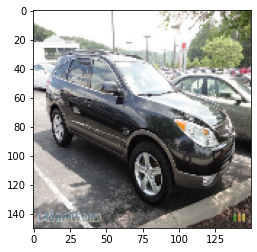

In [37]:
plt.imshow(x_test[1])

In [51]:
test = "/content/drive/My Drive/car.jpg"

In [52]:
def show_img(image_link):
  img = Image.open(image_link)
  plt.imshow(img)

In [59]:
def predict(image_link):
  img = Image.open(image_link)
  test_array = np.array(img)
  new_array = cv2.resize(test_array, (IMG_SIZE, IMG_SIZE))
  new_array = new_array/255
  new_array = new_array.reshape(-1,150,150,3)
  pred = np.argmax(model2.predict(new_array))
  print('It belongs to the class of: {}'.format(CATEGORIES[pred])) 

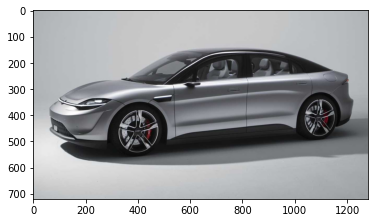

In [54]:
show_img("/content/drive/My Drive/car.jpg")

In [60]:
predict("/content/drive/My Drive/car.jpg")

It belongs to the class of: 01-whole
